In [1]:
import pickle 
import lzma
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from functions.SBC import SBC_epsilon,plot_SBC,find_grid_explorative
from jax import config, vmap, jit, random
import jax.numpy as jnp

In [2]:


@jit
def elu(x):
    return jnp.where(x > 0, x, jnp.exp(x) - 1)

 
def true_post(z):
    mu_post = (MU0*SIGMA**2 + SIGMA0**2 * np.sum(z))/(SIGMA0**2*len(z) + SIGMA**2)
    sigma2_post = 1/(1/SIGMA0**2 + len(z)/SIGMA**2)
    return stats.norm(loc = mu_post, scale = np.sqrt(sigma2_post))

config.update("jax_enable_x64", True)


@jit
def logratio_z(params, mus, z):
    activations = jnp.append(jnp.array([mus]),z)
    for w, b in params[:-1]:
        outputs = jnp.dot(w, activations) + b
        activations = elu(outputs)
    final_w, final_b = params[-1]
    logits = jnp.dot(final_w, activations) + final_b
    return logits[0]-logits[1]

logratio_batch_z = (vmap(logratio_z, in_axes = (None, 0,  None)))

def post_pdf_z(params, mus, z, prior):
    logpdf = prior.logpdf(mus)
    logr = logratio_batch_z(params, mus, z)
    return jnp.exp(logpdf+logr)



In [41]:
import os
SIGMA0 = 10.
MU = SIGMA0/10
name = 'Gaussian_notsort_sortdist'
pickle_files = [f for f in os.listdir(f'./new_new_pickle/new_new_pickle/{name}/') if f.endswith('.xz')]
loaded_data = {}

load_datas = {}

for file in pickle_files:
    file_parts = file.split('_')
    if float(file_parts[6])==SIGMA0 and float(file_parts[8])==MU:
        print(f"Loading {file}...", end = "")
        with lzma.open(f'./new_new_pickle/new_new_pickle/{name}/{file}', 'rb') as f:
            loaded_data[file] = pickle.load(f)
            
            ACCEPT_RATE = float(file_parts[10])
            load_datas[ACCEPT_RATE] = loaded_data[file]
            

            print(f" Loaded!")


Loading Gaussian_notsort_sortdist_sigma_1.0_sigma0_10.0_mu_1.0_acc_0.8_eps_0.12349.xz... Loaded!
Loading Gaussian_notsort_sortdist_sigma_1.0_sigma0_10.0_mu_1.0_acc_0.999_eps_364.38.xz... Loaded!
Loading Gaussian_notsort_sortdist_sigma_1.0_sigma0_10.0_mu_1.0_acc_0.975_eps_5.8688.xz... Loaded!
Loading Gaussian_notsort_sortdist_sigma_1.0_sigma0_10.0_mu_1.0_acc_0.925_eps_0.58743.xz... Loaded!
Loading Gaussian_notsort_sortdist_sigma_1.0_sigma0_10.0_mu_1.0_acc_0.9_eps_0.3668.xz... Loaded!
Loading Gaussian_notsort_sortdist_sigma_1.0_sigma0_10.0_mu_1.0_acc_0.99_eps_34.296.xz... Loaded!
Loading Gaussian_notsort_sortdist_sigma_1.0_sigma0_10.0_mu_1.0_acc_1.0_eps_inf.xz... Loaded!
Loading Gaussian_notsort_sortdist_sigma_1.0_sigma0_10.0_mu_1.0_acc_0.95_eps_1.3099.xz... Loaded!


In [17]:
load_datas.keys()

dict_keys([0.95, 0.999, 0.7, 1.0, 0.975, 0.6, 0.8, 0.925, 0.9, 0.75, 0.99, 0.5])

In [13]:
ACCEPT_RATES = sorted(load_datas.keys())[::-1]
ACCEPT_RATES

[1.0]

In [39]:
load_datas[ACCEPT_RATES[0]].keys()

dict_keys(['ranks', 'thetas_tilde', 'thetas', 'epsilon', 'KEY', 'N_SBC', 'L', 'N_GRID_EXPLO', 'N_GRID_FINAL', 'TRUE_DATA', 'TRUE_THETA', 'params', 'train_accuracy', 'test_accuracy', 'MODEL_ARGS', 'PRIOR_ARGS', 'N_POINTS_TRAIN', 'N_POINTS_TEST', 'N_DATA', 'N_EPOCHS', 'LEARNING_RATE', 'PATIENCE', 'COOLDOWN', 'FACTOR', 'RTOL', 'ACCUMULATION_SIZE', 'LEARNING_RATE_MIN', 'BATCH_SIZE', 'NUM_BATCH', 'NUM_CLASSES', 'HIDDEN_SIZE', 'NUM_LAYERS', 'WDECAY'])

In [ ]:
def map_difference(params, prior_gen)

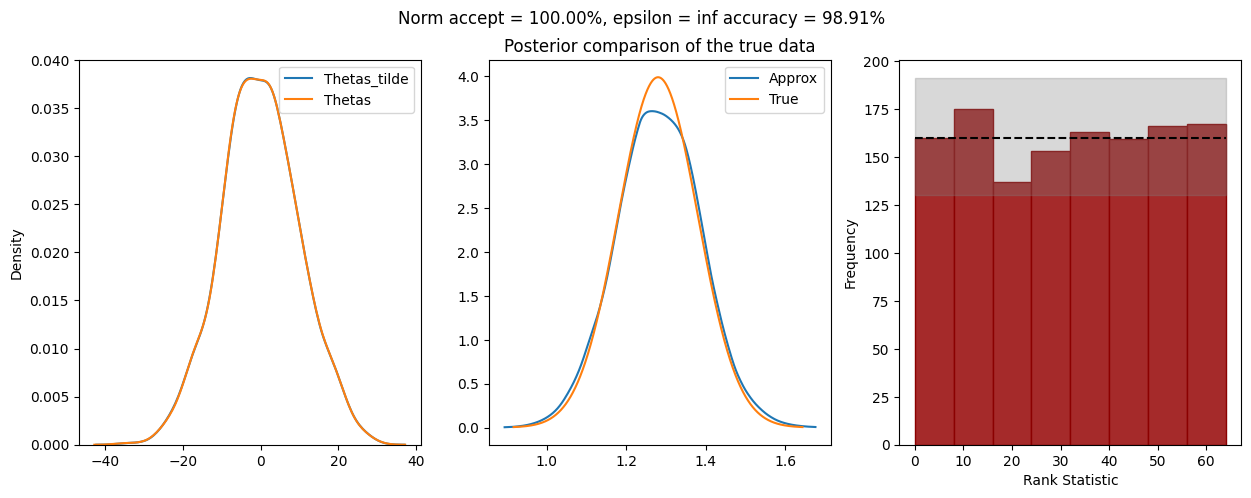

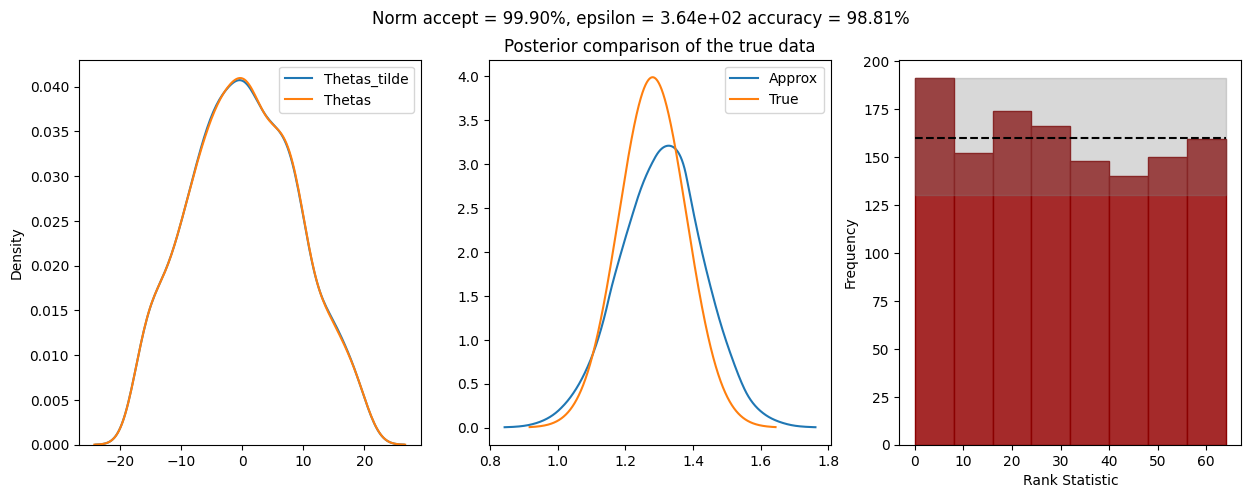

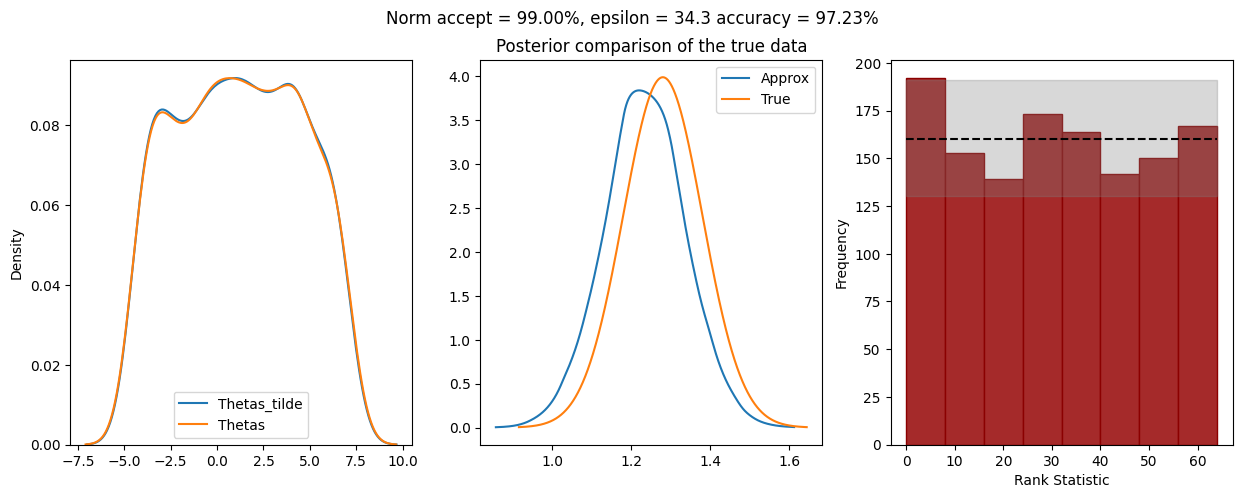

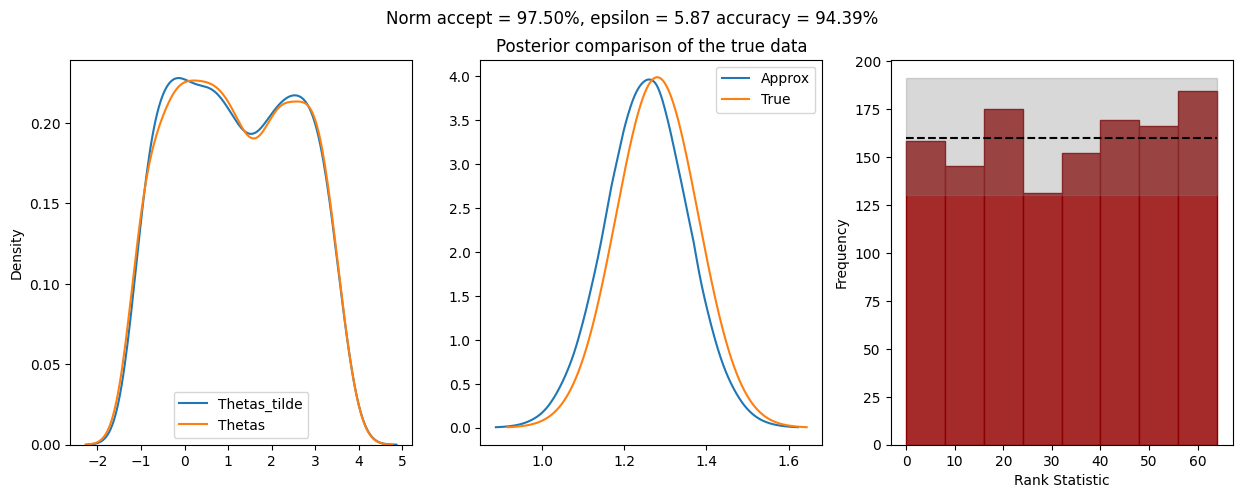

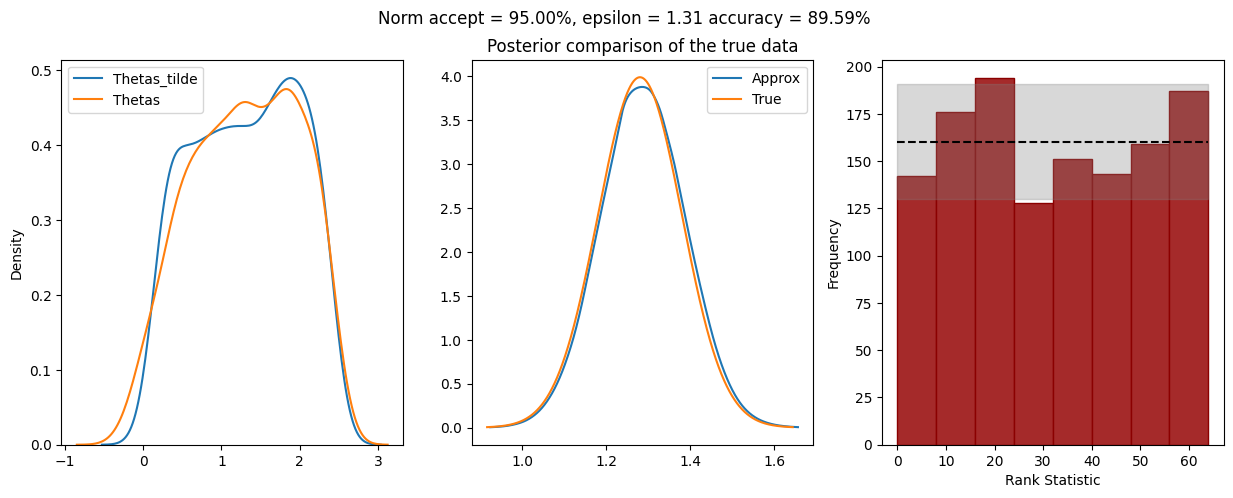

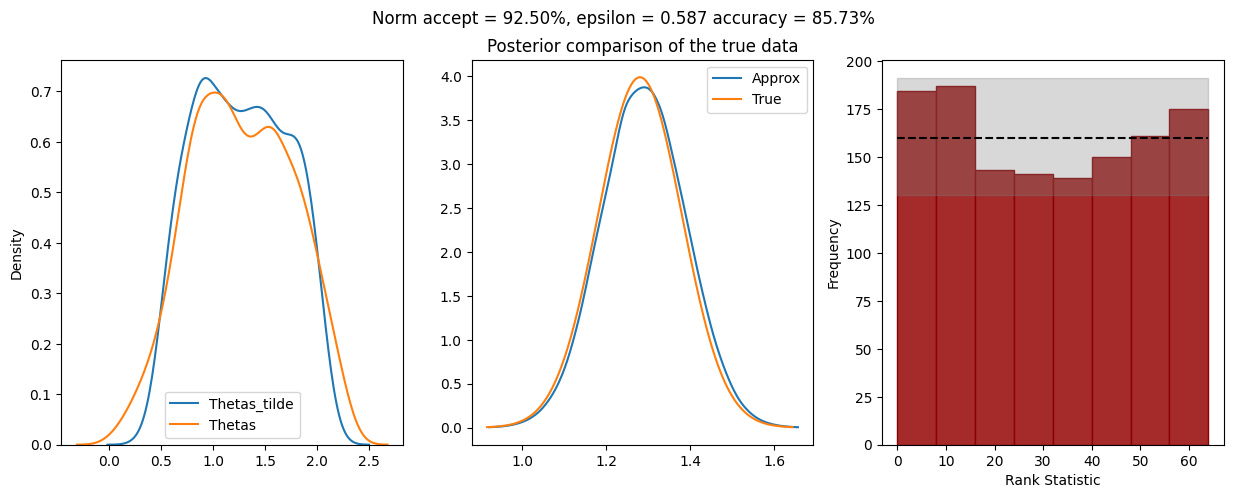

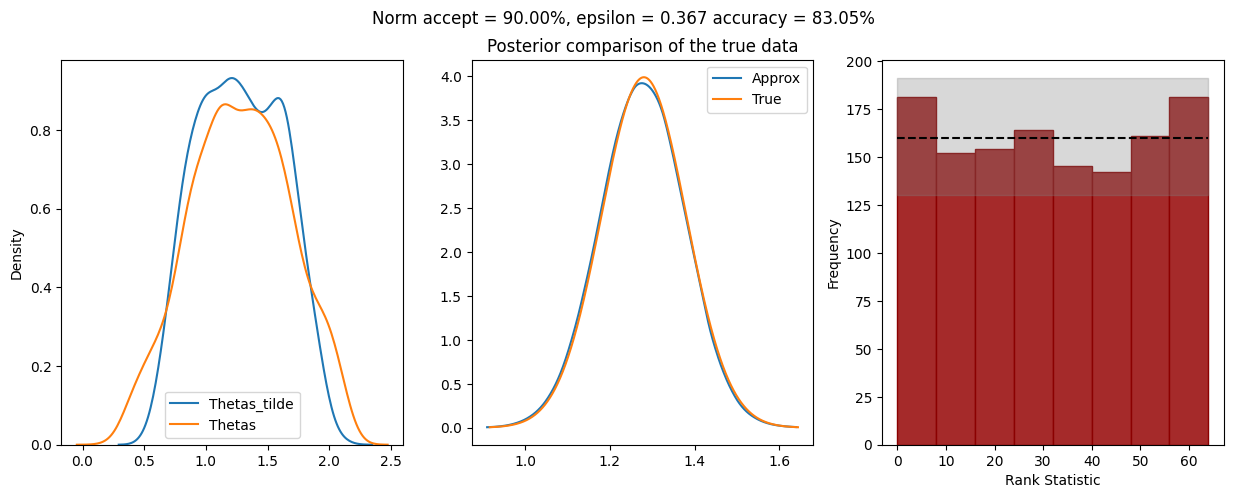

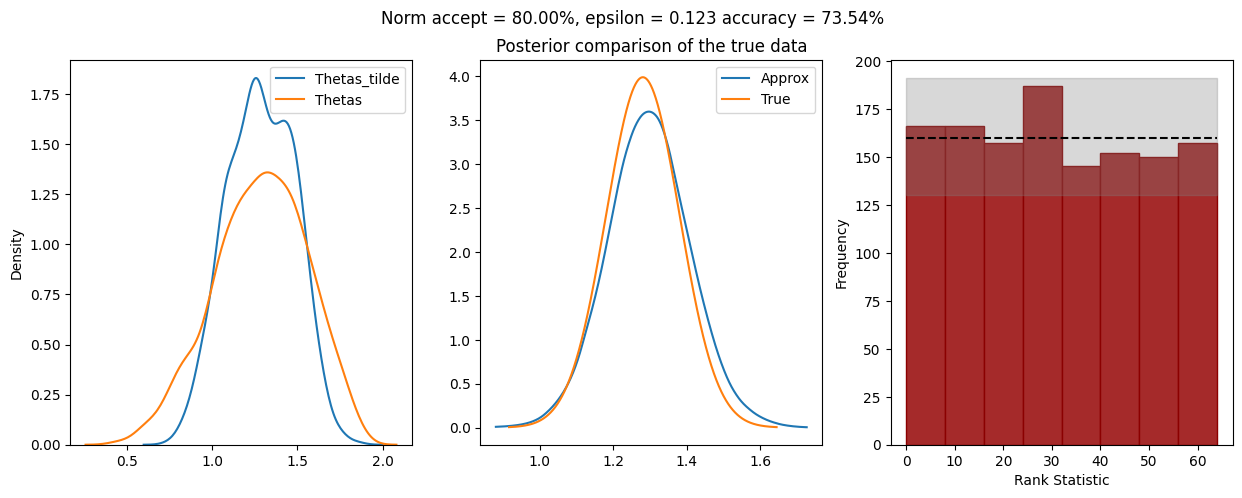

In [42]:
ACCEPT_RATES = sorted(load_datas.keys())[::-1]
B = 8
L = 63
for ACCEPT_RATE in ACCEPT_RATES:
        ranks = load_datas[ACCEPT_RATE]['ranks']
        thetas = load_datas[ACCEPT_RATE]['thetas']
        thetas_tilde = load_datas[ACCEPT_RATE]['thetas_tilde']
        params = load_datas[ACCEPT_RATE]['params']
        TRUE_DATA = load_datas[ACCEPT_RATE]['TRUE_DATA']
        MU0 = load_datas[ACCEPT_RATE]['PRIOR_ARGS'][0]
        SIGMA0 = load_datas[ACCEPT_RATE]['PRIOR_ARGS'][1]
        SIGMA = load_datas[ACCEPT_RATE]['MODEL_ARGS'][0]
        EPSILON_STAR = load_datas[ACCEPT_RATE]['epsilon']
        accuracy = load_datas[ACCEPT_RATE]['test_accuracy'][-1]
        PRIOR = stats.norm(loc = MU0, scale = SIGMA0)
        f, ax = plt.subplots(1,3, figsize = (15,5))
        sns.kdeplot(thetas_tilde, label = "Thetas_tilde", ax = ax[0])
        sns.kdeplot(thetas[:,0], label = "Thetas", ax = ax[0])
        
        ax[0].legend()
        f.suptitle(f'Norm accept = {ACCEPT_RATE:.2%}, epsilon = {EPSILON_STAR:.3} accuracy = {accuracy:.2%}')
        
        grid_approx, pdf_approx = find_grid_explorative(lambda x: post_pdf_z(params, x, TRUE_DATA, PRIOR), 10000, 10000, -10, 10)
        grid_true, pdf_true = find_grid_explorative(lambda x: true_post(TRUE_DATA).pdf(x), 10000, 10000, -10, 10)
        Z_approx = np.trapz(pdf_approx, grid_approx)
        ax[1].plot(grid_approx, pdf_approx/Z_approx, label = "Approx")
        ax[1].plot(grid_true, pdf_true, label = "True")
        ax[1].legend()
        ax[1].set_title("Posterior comparison of the true data")
        plot_SBC(ranks, L, B, ax = ax[2])
        ax[2].set_title("SBC with Rank Statistics")
        
        
        

In [ ]:
@jit
def prior_simulator(key):
    return random.normal(key, (1,))*SIGMA0 + MU0

@jit
def data_simulator(key, theta):
    return (random.normal(key, (N_DATA,))*SIGMA + theta).astype(float)

@jit
def discrepancy(y, y_true):
    return ((jnp.mean(y)-jnp.mean(y_true))**2)


In [7]:
thetas.shape

(12800, 127)

In [37]:
from functions.simulation import ABC_epsilon
ACCEPT_RATE = 1.
N_DATA = 100
N_SIM = 10
EPSILON = load_datas[ACCEPT_RATE]['epsilon']
params = load_datas[ACCEPT_RATE]['params']
key = random.PRNGKey(0)
datas, thetas, dists, key = ABC_epsilon(key, N_SIM, prior_simulator, data_simulator, discrepancy, EPSILON, TRUE_DATA)
for i in range(10):
    
    grid_approx, pdf_approx = find_grid_explorative(lambda x: post_pdf_z(params, x, datas[i], PRIOR), 10000, 10000, -10, 10)
    grid_true, pdf_true = find_grid_explorative(lambda x: true_post(datas[i]).pdf(x), 10000, 10000, -10, 10)
    Z_approx = np.trapz(pdf_approx, grid_approx)
    plt.plot(grid_approx, pdf_approx/Z_approx, label = "Approx")
    plt.plot(grid_true, pdf_true, label = "True")
    plt.legend()
    plt.title("Posterior comparison of the true data")
    plt.show()

NameError: name 'prior_simulator' is not defined

In [9]:
from functions.SBC import SBC_epsilon,plot_SBC,find_grid_explorative
from jax.scipy.stats import norm
PRIOR_LOGPDF = lambda x: norm.logpdf(x, loc = MU0, scale = SIGMA0)

ACCEPT_RATES = [1., .925, .8]
EPSILONS = [load_datas[ACCEPT_RATE]['epsilon'] for ACCEPT_RATE in ACCEPT_RATES]
L = 127
N_GRID_FINAL = 10000
N_GRID_EXPLO = 1000
MINN, MAXX = -50.,50. 
N_SBC = (L+1)*100
sbcs = {}
for acc_sbc in ACCEPT_RATES:
    sbc = {}
    for acc_nn in ACCEPT_RATES:
        print(f"Running SBC for Epsilons: SBC = {load_datas[acc_sbc]['epsilon']:.2}, NN = {load_datas[acc_nn]['epsilon']:.2}")
        ranks, thetas, thetas_tilde, key = SBC_epsilon(key = key, N_SBC = N_SBC, L = L, prior_simulator = prior_simulator, data_simulator = data_simulator, discrepancy = discrepancy, epsilon = load_datas[acc_nn]['epsilon'], true_data = TRUE_DATA, params = load_datas[acc_sbc]['params'], prior_logpdf = PRIOR_LOGPDF, minn = MINN, maxx = MAXX, n_grid_final = N_GRID_FINAL, n_grid_explo = N_GRID_EXPLO)
        dico = {"ranks": ranks, "thetas": thetas, "thetas_tilde": thetas_tilde}
        sbc[acc_nn] = dico
    sbcs[acc_sbc] = sbc

    

Running SBC for Epsilons: SBC = inf, NN = inf


  0%|          | 0/12800 [00:00<?, ?it/s]

Running SBC for Epsilons: SBC = 0.52, NN = 0.52


  0%|          | 0/12800 [00:00<?, ?it/s]

Running SBC for Epsilons: SBC = 0.081, NN = 0.081


  0%|          | 0/12800 [00:00<?, ?it/s]

Running SBC for Epsilons: SBC = inf, NN = inf


  0%|          | 0/12800 [00:00<?, ?it/s]

Running SBC for Epsilons: SBC = 0.52, NN = 0.52


  0%|          | 0/12800 [00:00<?, ?it/s]

Running SBC for Epsilons: SBC = 0.081, NN = 0.081


  0%|          | 0/12800 [00:00<?, ?it/s]

Running SBC for Epsilons: SBC = inf, NN = inf


  0%|          | 0/12800 [00:00<?, ?it/s]

Running SBC for Epsilons: SBC = 0.52, NN = 0.52


  0%|          | 0/12800 [00:00<?, ?it/s]

Running SBC for Epsilons: SBC = 0.081, NN = 0.081


  0%|          | 0/12800 [00:00<?, ?it/s]

In [ ]:
with lzma.open(f'./new_pickle/SBC_Grid_Norm_known_std_{SIGMA0}', 'wb') as f:
    pickle.dump(sbcs, f)

In [16]:
ACCEPT_RATES

[1.0, 0.925, 0.8]

In [15]:
print(ACCEPT_RATES)

[1.0, 0.925, 0.8]


# ABC SBC GRID

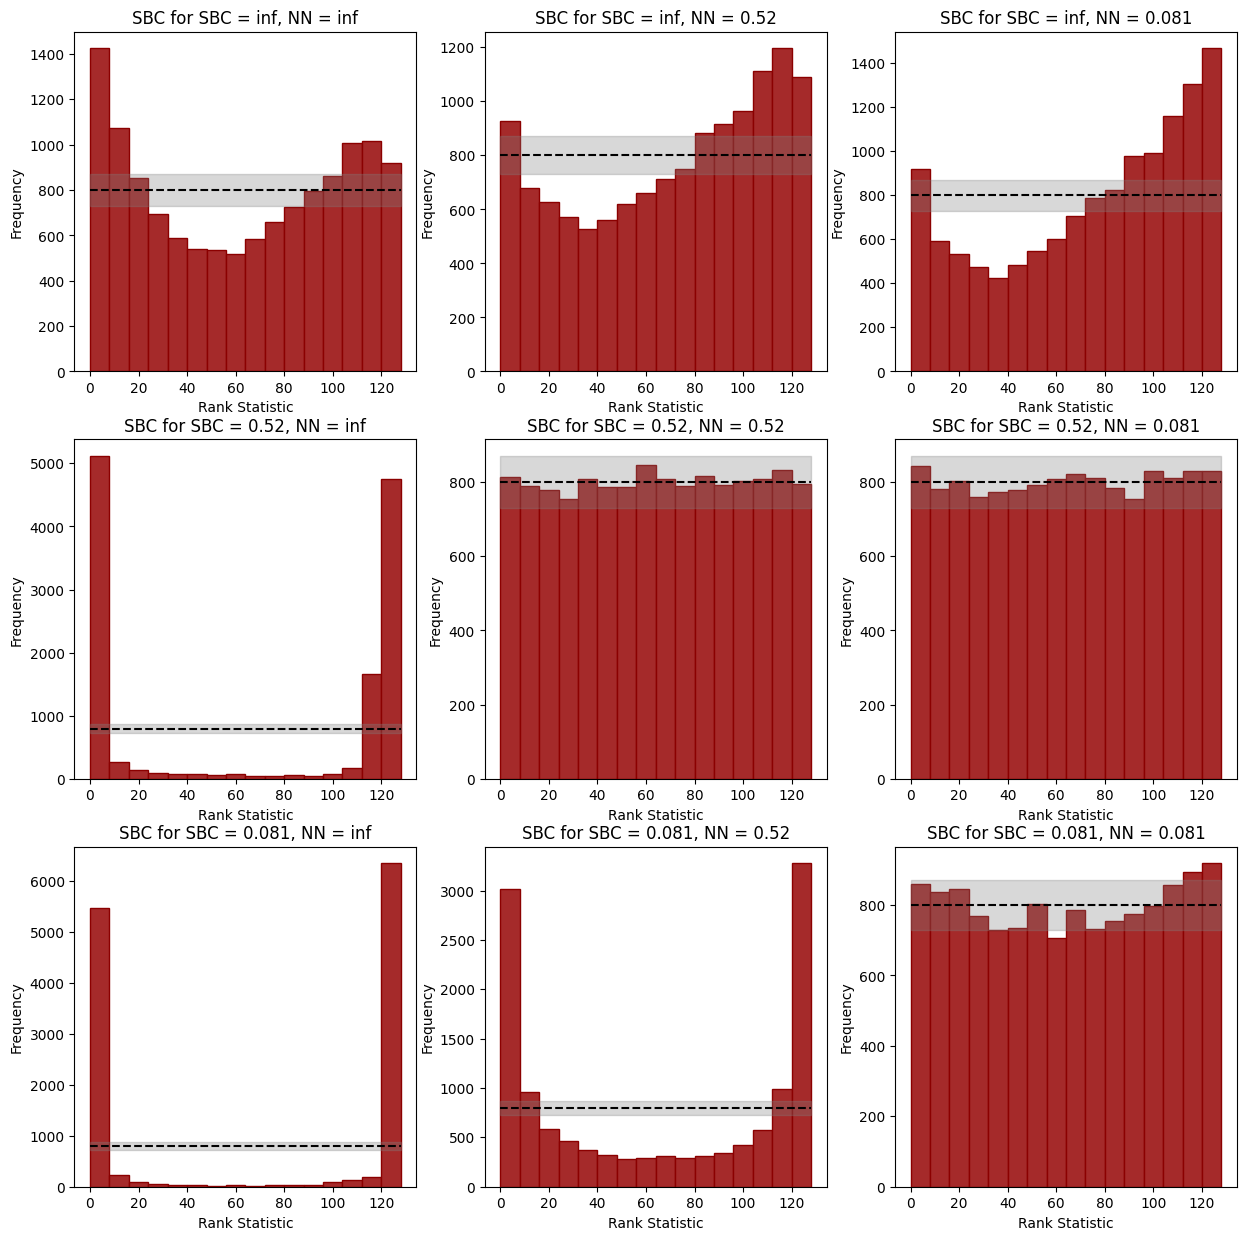

In [ ]:
f, ax = plt.subplots(3,3, figsize = (15,15))
for acc_sbc in ACCEPT_RATES:
    for acc_nn in ACCEPT_RATES:
        ranks = sbcs[acc_sbc][acc_nn]["ranks"]
        plot_SBC(ranks, L, 16, ax = ax[ACCEPT_RATES.index(acc_sbc), ACCEPT_RATES.index(acc_nn)], show = False)
        ax[ACCEPT_RATES.index(acc_sbc), ACCEPT_RATES.index(acc_nn)].set_title(f"SBC for SBC = {load_datas[acc_sbc]['epsilon']:.2}, NN = {load_datas[acc_nn]['epsilon']:.2}")

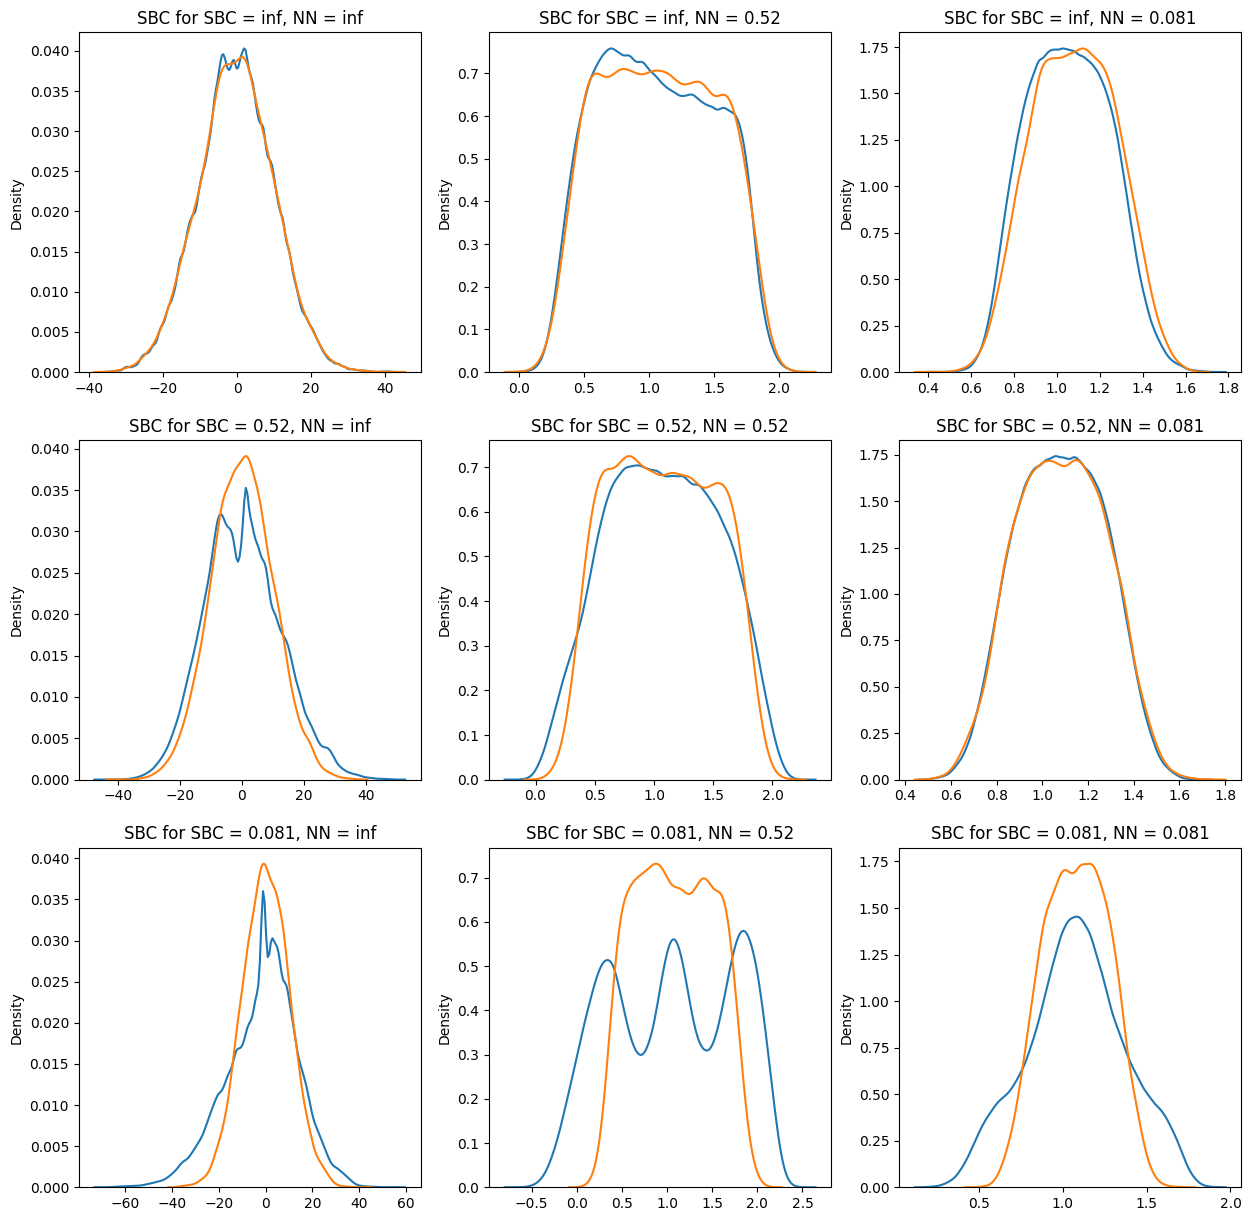

In [20]:
f, ax = plt.subplots(3,3, figsize = (15,15))
for acc_sbc in ACCEPT_RATES:
    for acc_nn in ACCEPT_RATES:
        ranks = sbcs[acc_sbc][acc_nn]["ranks"]
        thetas = sbcs[acc_sbc][acc_nn]["thetas"]
        thetas_tilde = sbcs[acc_sbc][acc_nn]["thetas_tilde"]
        sns.kdeplot(thetas_tilde.flatten(), label = "Thetas_tilde", ax = ax[ACCEPT_RATES.index(acc_sbc), ACCEPT_RATES.index(acc_nn)])
        sns.kdeplot(thetas[:,0].flatten(), label = "Thetas", ax = ax[ACCEPT_RATES.index(acc_sbc), ACCEPT_RATES.index(acc_nn)])
        ax[ACCEPT_RATES.index(acc_sbc), ACCEPT_RATES.index(acc_nn)].set_title(f"SBC for SBC = {load_datas[acc_sbc]['epsilon']:.2}, NN = {load_datas[acc_nn]['epsilon']:.2}")

In [24]:
thetas.shape, thetas_tilde.shape

((12800, 127), (12800, 1))

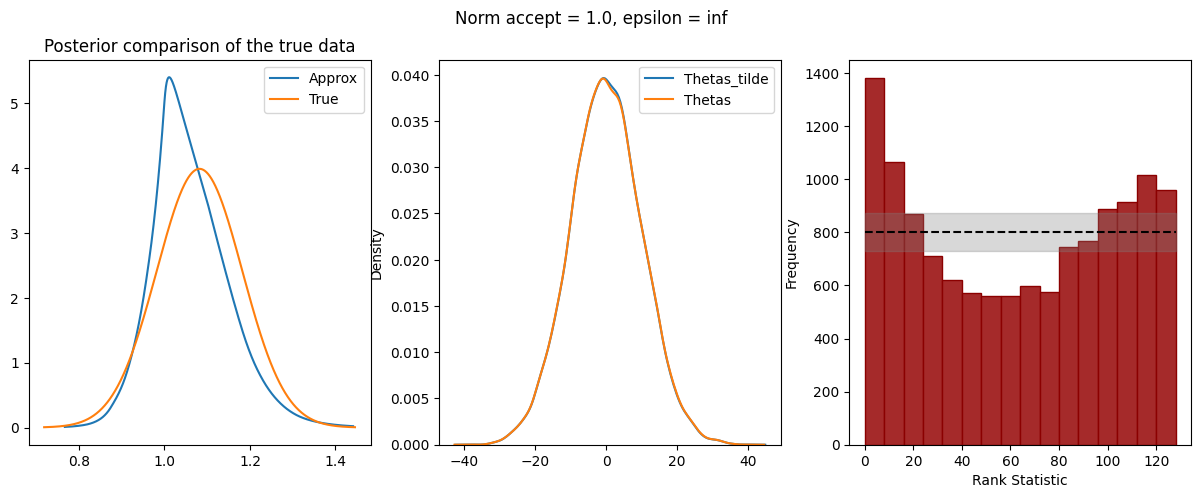

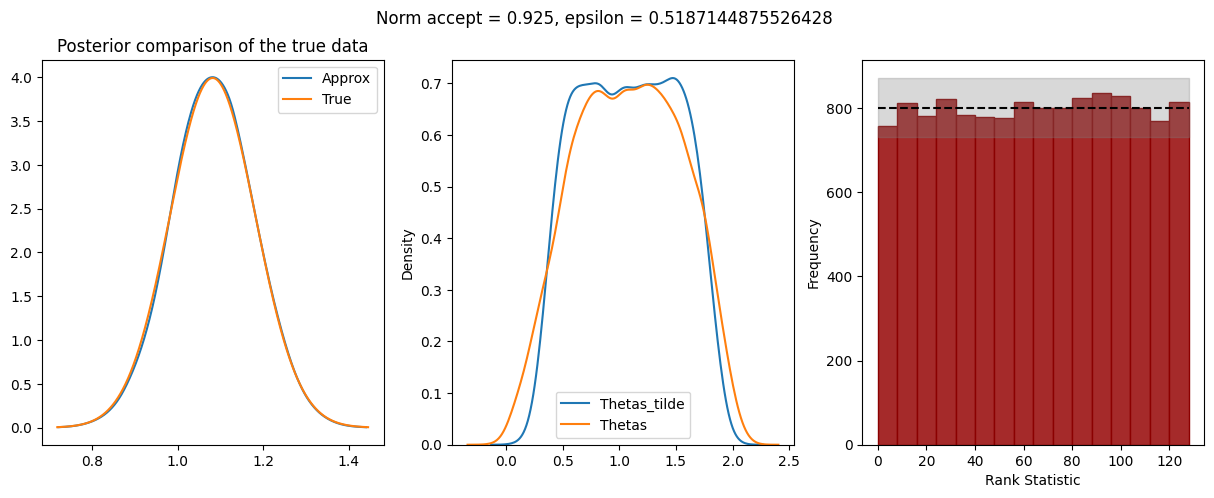

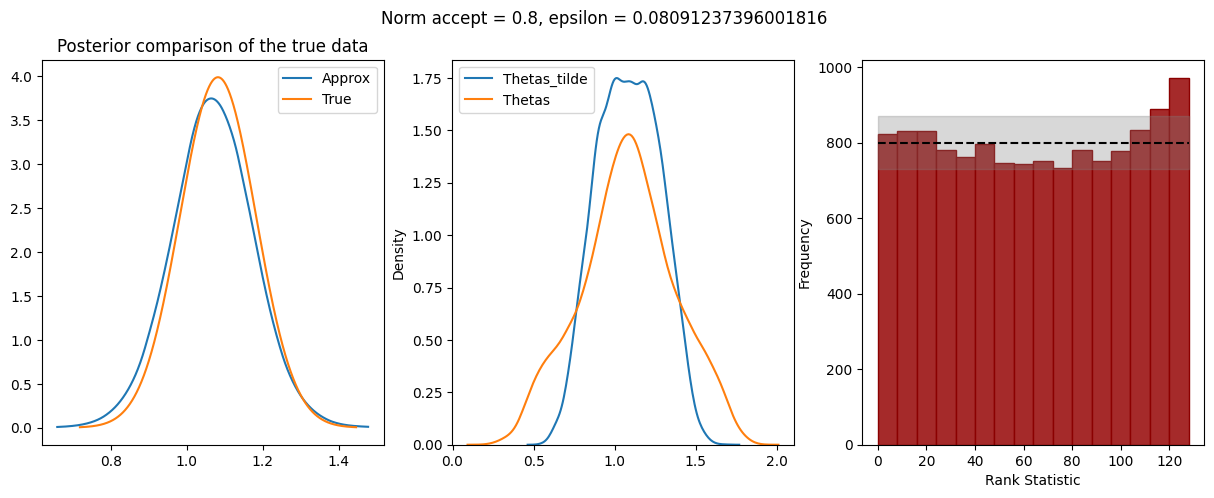

In [26]:
ACCEPT_RATES = [1., .925, .8]
B = 16
for ACCEPT_RATE in ACCEPT_RATES:
        ranks = load_datas[ACCEPT_RATE]['ranks']
        thetas = load_datas[ACCEPT_RATE]['thetas']
        thetas_tilde = load_datas[ACCEPT_RATE]['thetas_tilde']
        params = load_datas[ACCEPT_RATE]['params']
        TRUE_DATA = load_datas[ACCEPT_RATE]['TRUE_DATA']
        MU0 = load_datas[ACCEPT_RATE]['PRIOR_ARGS'][0]
        SIGMA0 = load_datas[ACCEPT_RATE]['PRIOR_ARGS'][1]
        SIGMA = load_datas[ACCEPT_RATE]['MODEL_ARGS'][0]
        EPSILON_STAR = load_datas[ACCEPT_RATE]['epsilon']

        PRIOR = stats.norm(loc = MU0, scale = SIGMA0)
        f, ax = plt.subplots(1,3, figsize = (15,5))
        
        grid_approx, pdf_approx = find_grid_explorative(lambda x: post_pdf_z(params, x, TRUE_DATA, PRIOR), 10000, 10000, -10, 10)
        grid_true, pdf_true = find_grid_explorative(lambda x: true_post(TRUE_DATA).pdf(x), 10000, 10000, -10, 10)
        Z_approx = np.trapz(pdf_approx, grid_approx)
        ax[0].plot(grid_approx, pdf_approx/Z_approx, label = "Approx")
        ax[0].plot(grid_true, pdf_true, label = "True")
        ax[0].legend()
        ax[0].set_title("Posterior comparison of the true data")
        
        
        sns.kdeplot(thetas_tilde, label = "Thetas_tilde", ax = ax[1])
        sns.kdeplot(thetas[:,1], label = "Thetas", ax = ax[1])
        
        ax[1].legend()
        f.suptitle(f'Norm accept = {ACCEPT_RATE}, epsilon = {EPSILON_STAR}')
        
        
        plot_SBC(ranks, 127, B, ax = ax[2])
        ax[2].set_title("SBC with Rank Statistics")
    

In [10]:
EPSILONS = [loaded_data[file]['epsilon'] for file in pickle_files if file.startswith("Norm_known_std")]
import os

import os

pickle_files = [f for f in os.listdir('./pickle') if f.endswith('.xz')]
loaded_data = {}

datas = {}
EPSILONS, ACCEPT_RATES, PARAMS, TRUE_DATAS = [], [], [], []
for file in pickle_files:
    file_parts = file.split('_')
    if file_parts[:3] == ["Norm", "known", "std"]:
        print(f"Loading {file}...", end = "")
        with lzma.open(f'./pickle/{file}', 'rb') as f:
            loaded_data[file] = pickle.load(f)
            EPSILONS.append(loaded_data[file]['epsilon'])
            ACCEPT_RATES.append(float(file_parts[8]))
            PARAMS.append(loaded_data[file]['params'])
            TRUE_DATAS.append(loaded_data[file]['TRUE_DATA'])
        print(f" Loaded!")

TRUE_DATA = np.array(TRUE_DATAS[0])


KeyError: 'Norm_known_std_sigma_1.0_sigma0_5.0_acc_0.975_eps_4.4798.xz'

In [ ]:

TRUE_DATA = np.array(TRUE_DATAS[0])
np.unique(TRUE_DATAS, axis = 0)

array([[-0.9810703 , -0.9732719 , -0.9712908 , -0.8061263 , -0.69251084,
        -0.5120755 , -0.39450037, -0.37480664, -0.25243127, -0.23356557,
        -0.18450908, -0.02502609,  0.0431896 ,  0.05264145,  0.1962957 ,
         0.20421475,  0.20694813,  0.23182607,  0.24948855,  0.2692261 ,
         0.29461873,  0.30856347,  0.31209496,  0.41787827,  0.41914082,
         0.5015748 ,  0.5217433 ,  0.5448524 ,  0.5794781 ,  0.5891697 ,
         0.60789853,  0.6103141 ,  0.6161758 ,  0.66256195,  0.7727834 ,
         0.7732044 ,  0.7798045 ,  0.8365337 ,  0.8523717 ,  0.9132634 ,
         0.91408455,  0.93075514,  0.9499644 ,  0.9586579 ,  0.9729108 ,
         1.013208  ,  1.0312455 ,  1.035166  ,  1.0500787 ,  1.0606928 ,
         1.0669487 ,  1.091247  ,  1.1354915 ,  1.1553881 ,  1.1626376 ,
         1.2013121 ,  1.2211316 ,  1.2728574 ,  1.278623  ,  1.2813405 ,
         1.2849271 ,  1.3250202 ,  1.3759753 ,  1.3806326 ,  1.3979522 ,
         1.4414523 ,  1.4611369 ,  1.4865426 ,  1.4

In [ ]:
import time 
N_SBC = 10
L = 100
N_GRID_EXPLO = 10
N_GRID_FINAL = 100
MINN, MAXX = -10, 10
from jax.scipy.stats import norm
PRIOR_LOGPDF = lambda x: norm.logpdf(x, loc = MU0, scale = SIGMA0) 
dico = {}
for i in range(len(EPSILONS)):
    dico_eps = {}
    for j in range(len(EPSILONS)):
        
        print("ACCEPT_RATE SBC = {:.3%} ACCEPT_RATE NN = {:.3%}".format(ACCEPT_RATES[i], ACCEPT_RATES[j]))
        time_sbc = time.time()
        ranks, thetas_tilde, thetas, key = SBC_epsilon(key = key, N_SBC = N_SBC, L = L, params = PARAMS[j], epsilon = EPSILONS[i], true_data = TRUE_DATA, prior_simulator = prior_simulator, prior_logpdf = PRIOR_LOGPDF, data_simulator = data_simulator, discrepancy = discrepancy, n_grid_explo = N_GRID_EXPLO, n_grid_final = N_GRID_FINAL, minn = MINN, maxx = MAXX)
        dico_eps[ACCEPT_RATES[j]] = {"ranks": ranks, "thetas_tilde": thetas_tilde, "thetas": thetas}   
        print('Time to perform SBC: {:.2f}s\n'.format(time.time()-time_sbc))

    dico[ACCEPT_RATES[i]] = dico_eps

name = "./pickle/Norm_SBC_grid_sigma_{}_sigma0_{}.xz".format(SIGMA, SIGMA0)

with lzma.open(name, "wb") as f:
    pickle.dump(dico, f)
print("Data saved in ", name)




ACCEPT_RATE SBC = 99.000% ACCEPT_RATE NN = 99.000%


100%|██████████| 10/10 [00:00<00:00, 101.18it/s]


Time to perform SBC: 0.11s

ACCEPT_RATE SBC = 99.000% ACCEPT_RATE NN = 97.000%


100%|██████████| 10/10 [00:00<00:00, 124.28it/s]


Time to perform SBC: 0.09s

ACCEPT_RATE SBC = 99.000% ACCEPT_RATE NN = 95.000%


100%|██████████| 10/10 [00:00<00:00, 123.09it/s]


Time to perform SBC: 0.09s

ACCEPT_RATE SBC = 99.000% ACCEPT_RATE NN = 99.900%


100%|██████████| 10/10 [00:00<00:00, 117.65it/s]


Time to perform SBC: 0.09s

ACCEPT_RATE SBC = 99.000% ACCEPT_RATE NN = 100.000%


100%|██████████| 10/10 [00:00<00:00, 82.05it/s]


Time to perform SBC: 0.13s

ACCEPT_RATE SBC = 99.000% ACCEPT_RATE NN = 90.000%


100%|██████████| 10/10 [00:00<00:00, 70.36it/s] 


Time to perform SBC: 0.15s

ACCEPT_RATE SBC = 97.000% ACCEPT_RATE NN = 99.000%


100%|██████████| 10/10 [00:00<00:00, 129.33it/s]


Time to perform SBC: 0.09s

ACCEPT_RATE SBC = 97.000% ACCEPT_RATE NN = 97.000%


100%|██████████| 10/10 [00:00<00:00, 125.73it/s]


Time to perform SBC: 0.09s

ACCEPT_RATE SBC = 97.000% ACCEPT_RATE NN = 95.000%


100%|██████████| 10/10 [00:00<00:00, 106.77it/s]


Time to perform SBC: 0.10s

ACCEPT_RATE SBC = 97.000% ACCEPT_RATE NN = 99.900%


100%|██████████| 10/10 [00:00<00:00, 114.74it/s]


Time to perform SBC: 0.10s

ACCEPT_RATE SBC = 97.000% ACCEPT_RATE NN = 100.000%


100%|██████████| 10/10 [00:00<00:00, 92.11it/s]


Time to perform SBC: 0.12s

ACCEPT_RATE SBC = 97.000% ACCEPT_RATE NN = 90.000%


100%|██████████| 10/10 [00:00<00:00, 111.42it/s]


Time to perform SBC: 0.11s

ACCEPT_RATE SBC = 95.000% ACCEPT_RATE NN = 99.000%


100%|██████████| 10/10 [00:00<00:00, 91.22it/s] 


Time to perform SBC: 0.18s

ACCEPT_RATE SBC = 95.000% ACCEPT_RATE NN = 97.000%


100%|██████████| 10/10 [00:00<00:00, 121.26it/s]


Time to perform SBC: 0.09s

ACCEPT_RATE SBC = 95.000% ACCEPT_RATE NN = 95.000%


100%|██████████| 10/10 [00:00<00:00, 117.54it/s]


Time to perform SBC: 0.10s

ACCEPT_RATE SBC = 95.000% ACCEPT_RATE NN = 99.900%


100%|██████████| 10/10 [00:00<00:00, 116.25it/s]


Time to perform SBC: 0.10s

ACCEPT_RATE SBC = 95.000% ACCEPT_RATE NN = 100.000%


100%|██████████| 10/10 [00:00<00:00, 86.96it/s]


Time to perform SBC: 0.13s

ACCEPT_RATE SBC = 95.000% ACCEPT_RATE NN = 90.000%


100%|██████████| 10/10 [00:00<00:00, 115.88it/s]


Time to perform SBC: 0.11s

ACCEPT_RATE SBC = 99.900% ACCEPT_RATE NN = 99.000%


100%|██████████| 10/10 [00:00<00:00, 70.87it/s]


Time to perform SBC: 0.16s

ACCEPT_RATE SBC = 99.900% ACCEPT_RATE NN = 97.000%


100%|██████████| 10/10 [00:00<00:00, 90.99it/s]


Time to perform SBC: 0.12s

ACCEPT_RATE SBC = 99.900% ACCEPT_RATE NN = 95.000%


100%|██████████| 10/10 [00:00<00:00, 87.14it/s]


Time to perform SBC: 0.12s

ACCEPT_RATE SBC = 99.900% ACCEPT_RATE NN = 99.900%


100%|██████████| 10/10 [00:00<00:00, 93.23it/s]


Time to perform SBC: 0.11s

ACCEPT_RATE SBC = 99.900% ACCEPT_RATE NN = 100.000%


100%|██████████| 10/10 [00:00<00:00, 82.07it/s]


Time to perform SBC: 0.13s

ACCEPT_RATE SBC = 99.900% ACCEPT_RATE NN = 90.000%


100%|██████████| 10/10 [00:00<00:00, 83.24it/s]


Time to perform SBC: 0.13s

ACCEPT_RATE SBC = 100.000% ACCEPT_RATE NN = 99.000%


100%|██████████| 10/10 [00:00<00:00, 61.18it/s]


Time to perform SBC: 0.18s

ACCEPT_RATE SBC = 100.000% ACCEPT_RATE NN = 97.000%


100%|██████████| 10/10 [00:00<00:00, 44.59it/s]


Time to perform SBC: 0.29s

ACCEPT_RATE SBC = 100.000% ACCEPT_RATE NN = 95.000%


100%|██████████| 10/10 [00:00<00:00, 57.83it/s]


Time to perform SBC: 0.18s

ACCEPT_RATE SBC = 100.000% ACCEPT_RATE NN = 99.900%


100%|██████████| 10/10 [00:00<00:00, 63.78it/s]


Time to perform SBC: 0.16s

ACCEPT_RATE SBC = 100.000% ACCEPT_RATE NN = 100.000%


100%|██████████| 10/10 [00:00<00:00, 43.01it/s]


Time to perform SBC: 0.24s

ACCEPT_RATE SBC = 100.000% ACCEPT_RATE NN = 90.000%


100%|██████████| 10/10 [00:00<00:00, 72.21it/s]


Time to perform SBC: 0.15s

ACCEPT_RATE SBC = 90.000% ACCEPT_RATE NN = 99.000%


100%|██████████| 10/10 [00:00<00:00, 84.57it/s]


Time to perform SBC: 0.14s

ACCEPT_RATE SBC = 90.000% ACCEPT_RATE NN = 97.000%


100%|██████████| 10/10 [00:00<00:00, 49.50it/s]


Time to perform SBC: 0.23s

ACCEPT_RATE SBC = 90.000% ACCEPT_RATE NN = 95.000%


100%|██████████| 10/10 [00:00<00:00, 92.57it/s]


Time to perform SBC: 0.14s

ACCEPT_RATE SBC = 90.000% ACCEPT_RATE NN = 99.900%


100%|██████████| 10/10 [00:00<00:00, 94.48it/s]


Time to perform SBC: 0.13s

ACCEPT_RATE SBC = 90.000% ACCEPT_RATE NN = 100.000%


100%|██████████| 10/10 [00:00<00:00, 79.57it/s]


Time to perform SBC: 0.15s

ACCEPT_RATE SBC = 90.000% ACCEPT_RATE NN = 90.000%


100%|██████████| 10/10 [00:00<00:00, 97.19it/s] 


Time to perform SBC: 0.14s

Data saved in  ./pickle/Norm_SBC_grid_sigma_1.0_sigma0_10.0.xz


NameError: name 'EPSILON' is not defined

In [ ]:
file_path = './pickle/Norm_known_std_SBC_grid_sigma_1.0_sigma0_10.0.xz'

with lzma.open(file_path, 'rb') as f:
    data = pickle.load(f)

ACCEPT_RATES = sorted(data.keys())[::-1]
K = len(ACCEPT_RATES)

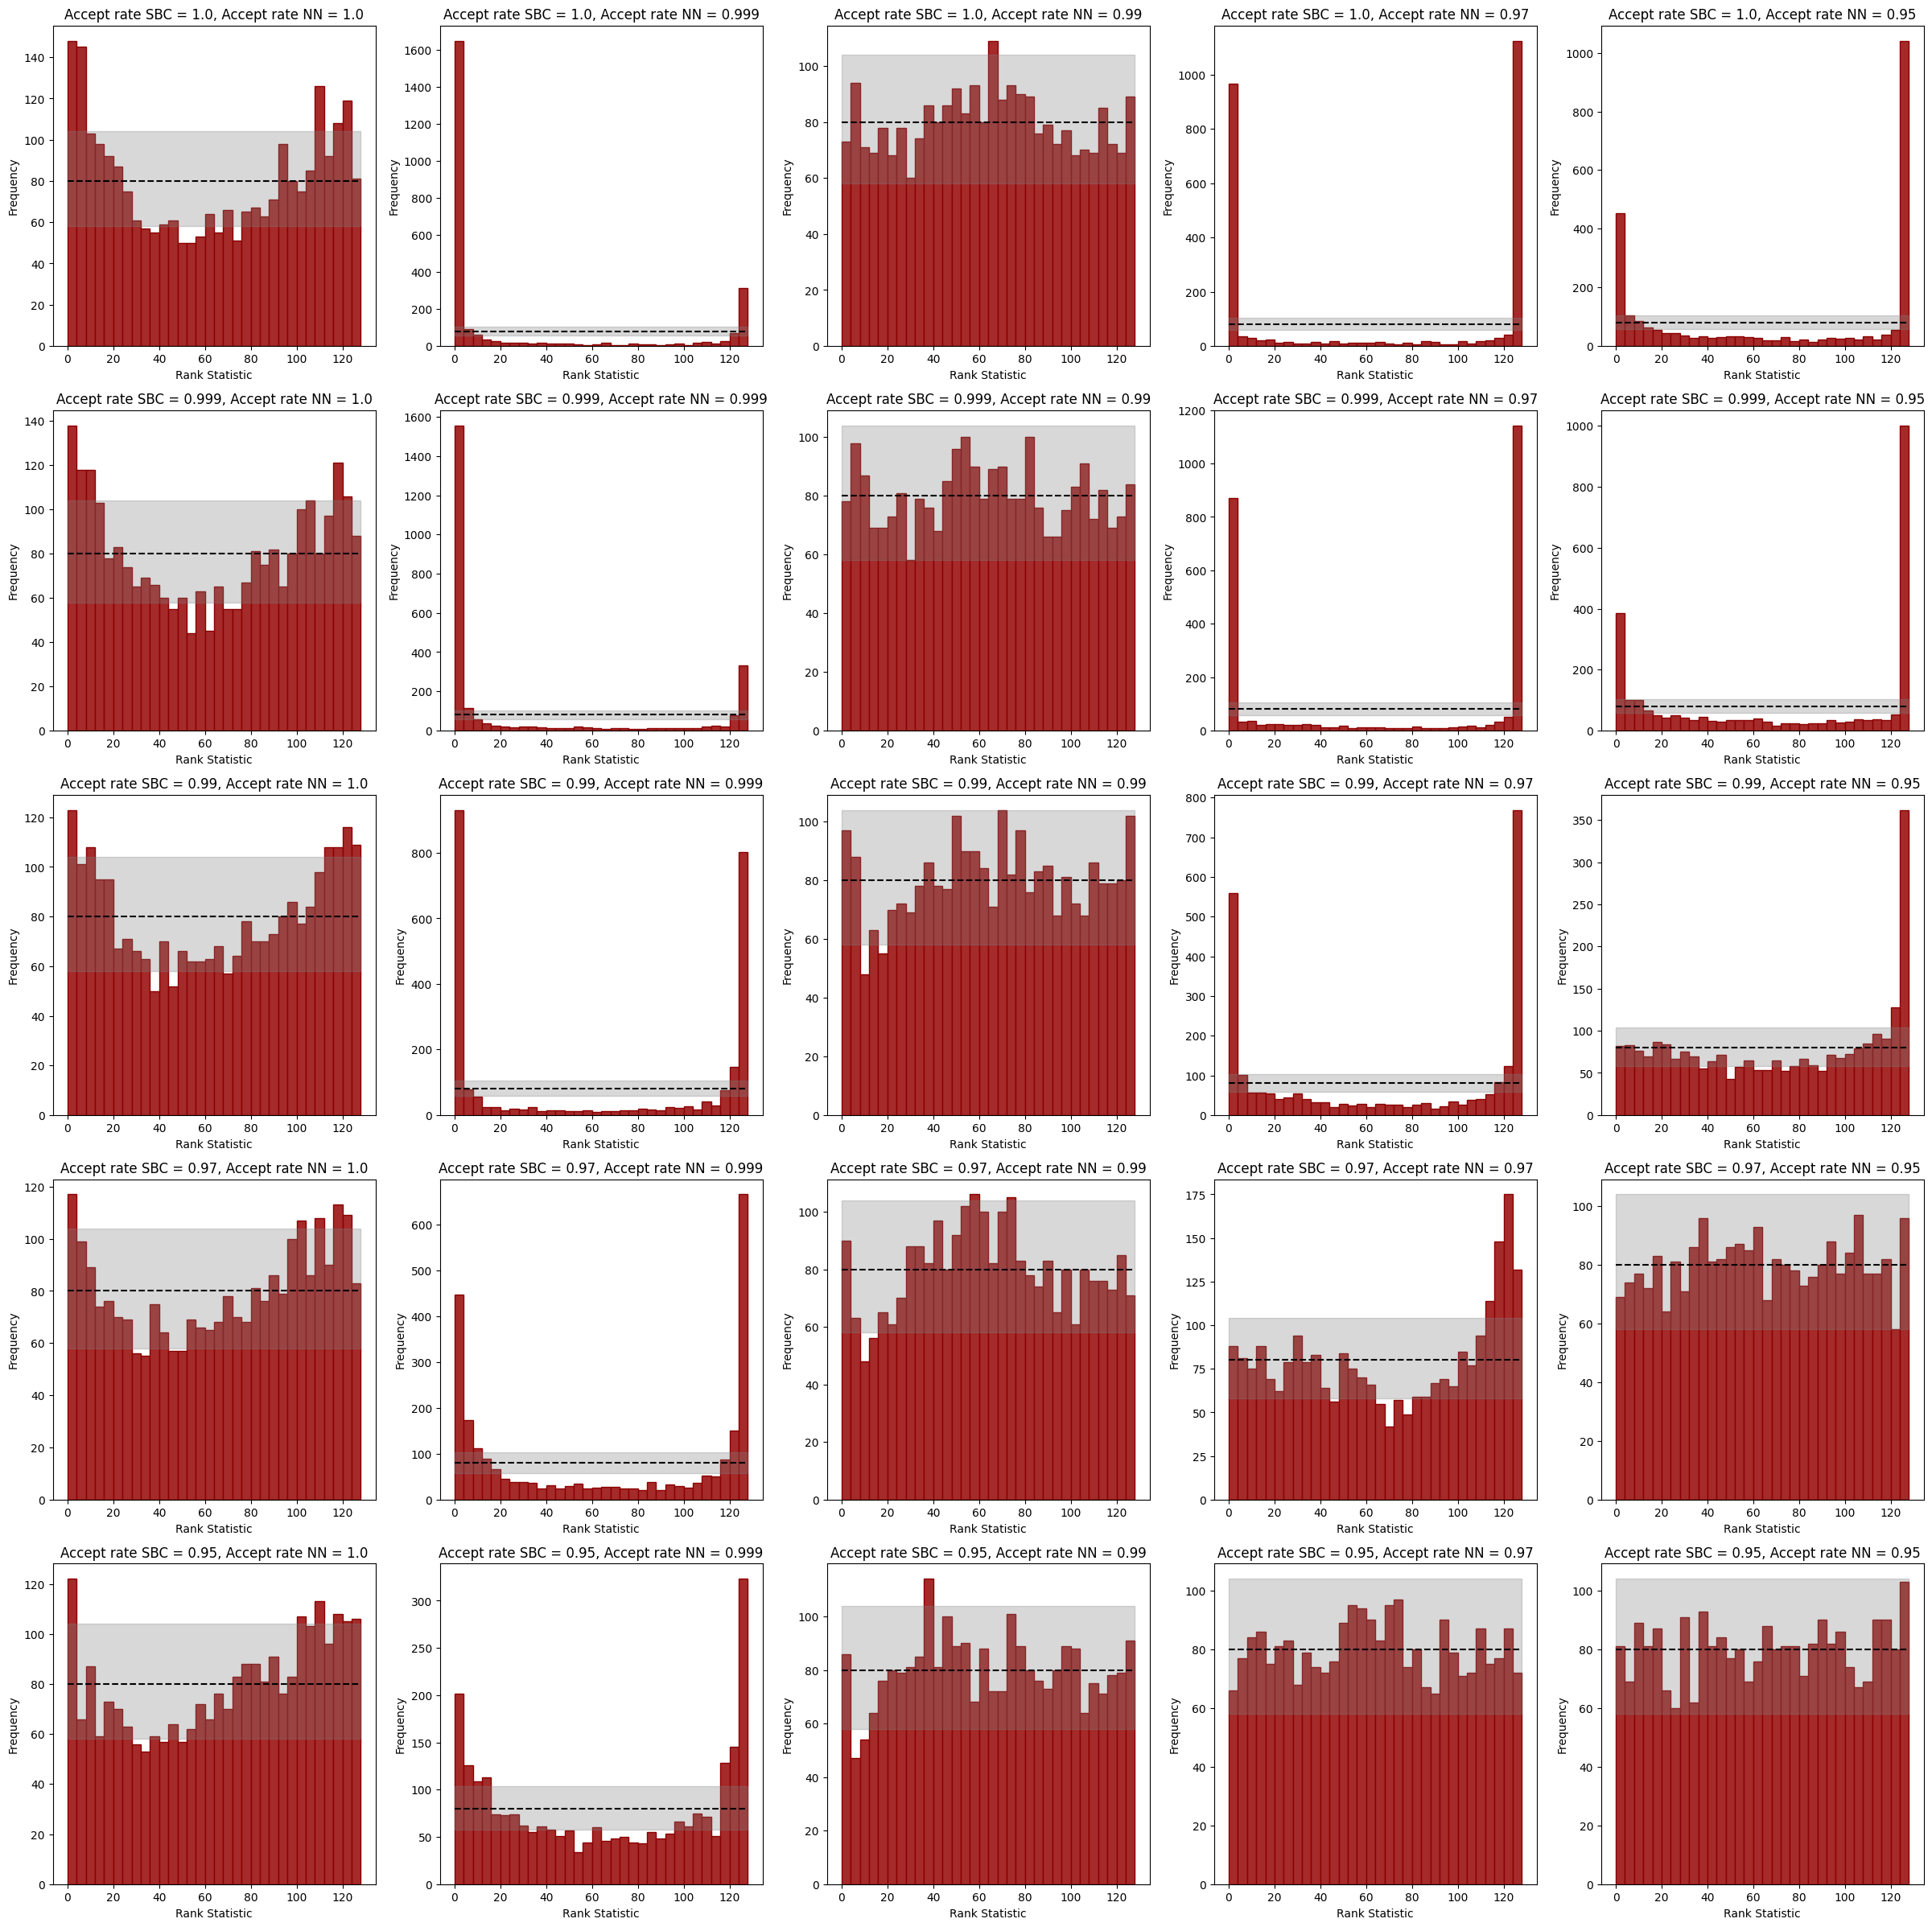

In [ ]:
f, ax = plt.subplots(K,K, figsize = (30,30))
for i, accept_rate in enumerate(ACCEPT_RATES):
    for j, accept_rate2 in enumerate(ACCEPT_RATES):
        ranks = data[accept_rate][accept_rate2]['ranks']
        title = f"$\a SBC = {accept_rate}, Accept rate NN = {accept_rate2}"
        plot_SBC(ranks, 127, 32, ax = ax[i,j], title = title, show = False)
plt.show()
        # ax[i,j].set_title(f"Accept rate SBC = {accept_rate}, Accept rate NN = {accept_rate2}")